In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

dataset = pd.read_excel('/content/drive/My Drive/Forecasting model/COVID_case_report_final.xlsx')

dataset

,City,Total Laboratory-confirmed case,difference to the previous day,hospitalized,Deceased,Recover-A,current cases-B,Reported the last 7 days,Rhineland-Palatinate,+USAFD,<20 years,20-59 years-E,≥ 60 years,Date
0,Ahrweiler,5627,9,213.0,58,5071,498,36,27.6,27.6,57.1,24.7,16.3,2021-10-01
1,Altenkirchen,5749,4,458.0,105,5467,177,46,35.6,35.6,45.8,45.7,12.7,2021-10-01
2,Alzey-Worms,6064,13,365.0,127,5591,346,124,94.9,94.8,241.7,82.6,18.6,2021-10-01
3,Bad Dürkheim,5129,16,336.0,154,4588,387,63,47.4,47.4,64.8,59.1,20.5,2021-10-01
4,Bad Kreuznach,7047,19,183.0,143,6237,667,95,59.8,59.8,120.4,57.8,27.9,2021-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16303,KS Pirmasens,15661,14,581.0,116,15311,234,57,142.3,142.3,86.3,112.7,213.6,2023-01-13 00:00:00
16304,KS Speyer,23002,11,515.0,130,22541,331,61,120.6,120.6,65.9,140.1,120.5,2023-01-13 00:00:00
16305,KS Trier,43350,42,392.0,73,42705,572,83,75.1,75.0,27.3,76.7,103.5,2023-01-13 00:00:00
16306,KS Worms,37936,4,1169.0,175,37346,415,72,85.9,85.9,18.2,91.2,123.2,2023-01-13 00:00:00


In [4]:
data = dataset.drop(['City','Total Laboratory-confirmed case',	'difference to the previous day','hospitalized','Deceased',
                     'Recover-A', 'Reported the last 7 days','Rhineland-Palatinate',	'+USAFD',	'<20 years','20-59 years-E','≥ 60 years'],axis=1)

In [5]:
data = data.dropna()
data.columns = ["current_cases","Date"]
data

,current_cases,Date
0,498,2021-10-01
1,177,2021-10-01
2,346,2021-10-01
3,387,2021-10-01
4,667,2021-10-01
...,...,...
16303,234,2023-01-13 00:00:00
16304,331,2023-01-13 00:00:00
16305,572,2023-01-13 00:00:00
16306,415,2023-01-13 00:00:00


In [6]:
data.dtypes

current_cases     int64
Date             object
dtype: object

In [7]:
# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set date column as index
data.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

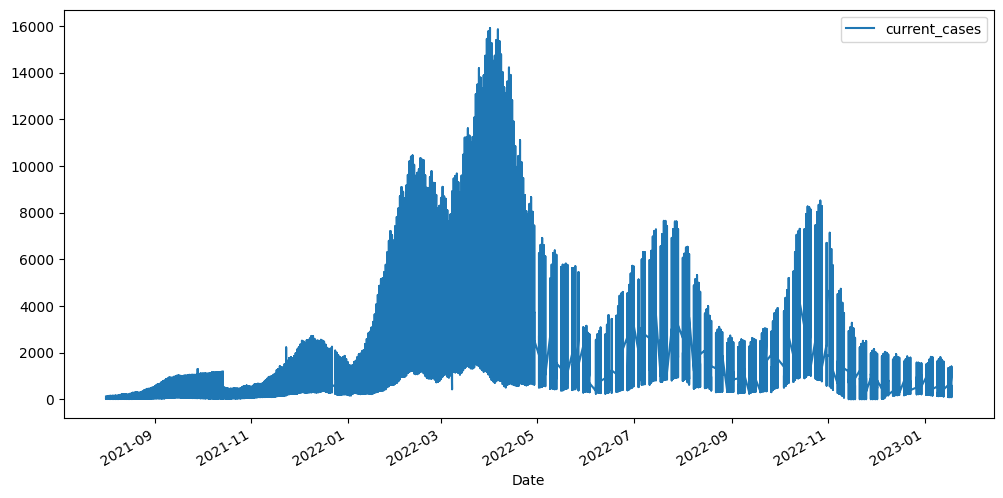

In [8]:
data.plot(figsize=(12,6))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

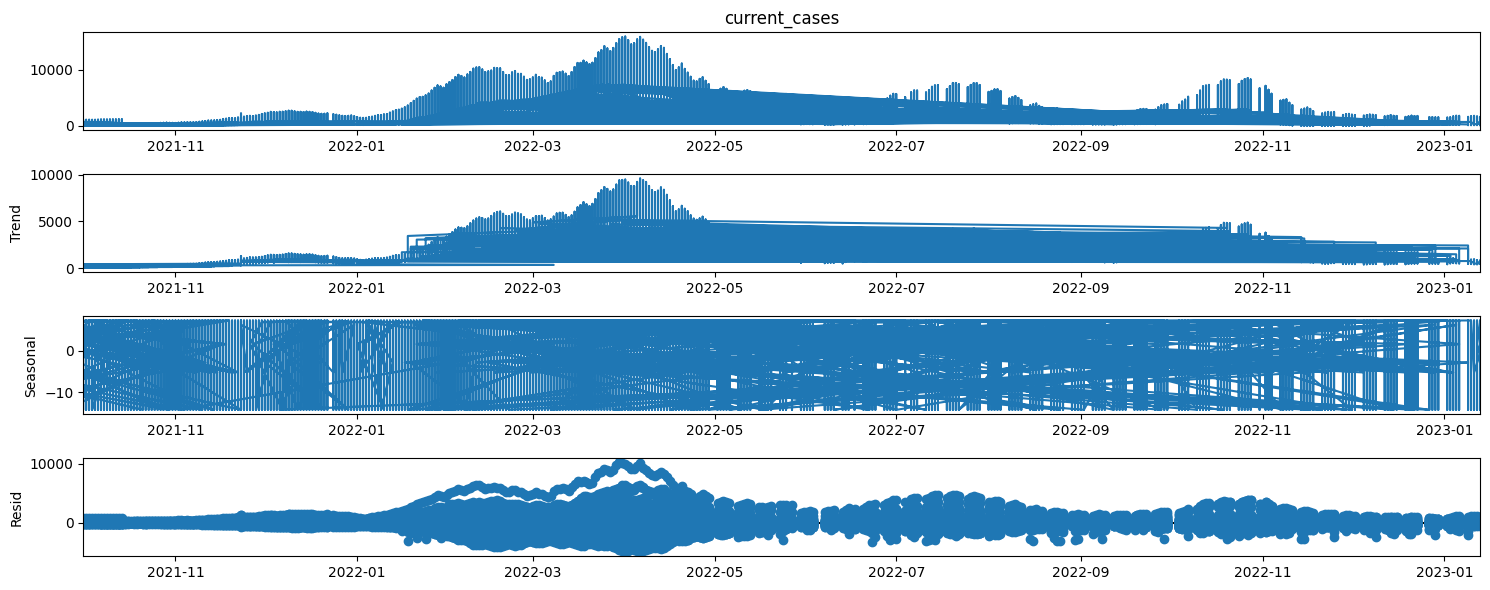

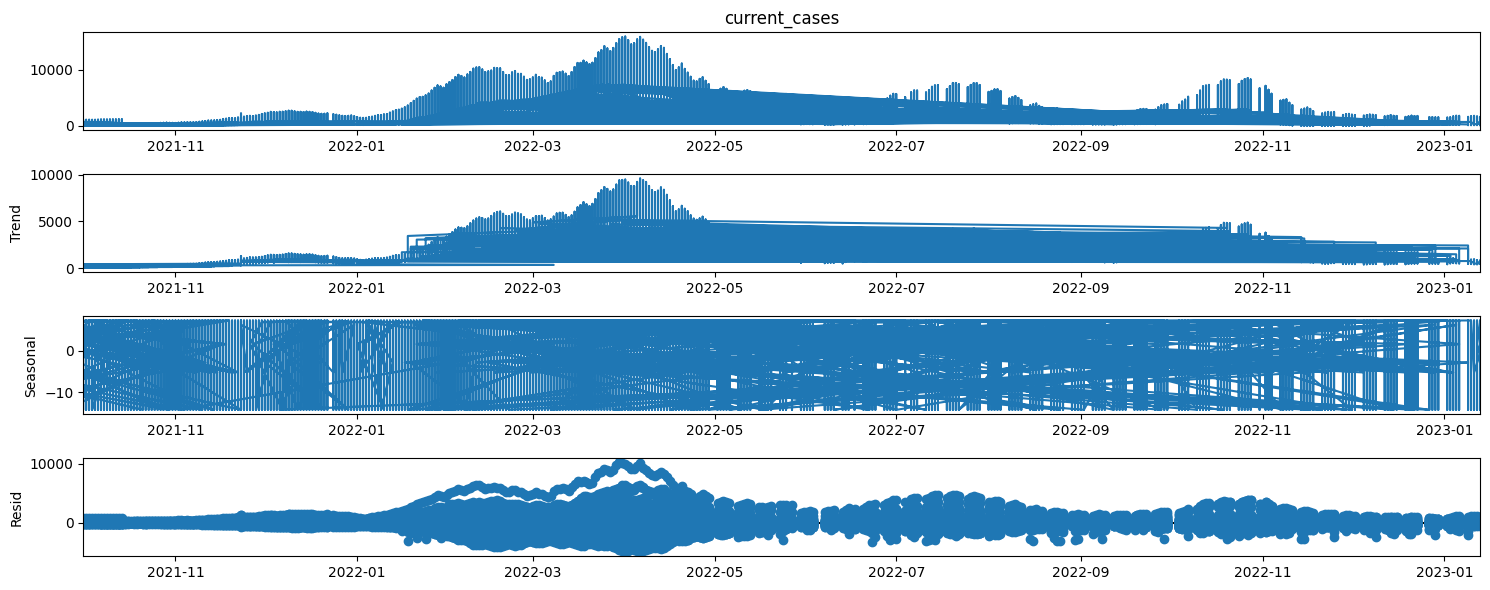

In [10]:
plt.rcParams["figure.figsize"] = (15,6)
output = seasonal_decompose(data['current_cases'],period=7)
output.plot()

In [11]:
# Remove the rows with missing values
data.dropna(inplace=True)

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Define the number of past days to use as input for prediction
look_back = 30

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert the data into sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), :])
        y.append([data[(i+look_back)]])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# Reshape the input data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
356/356 [==============================] - 9s 18ms/step - loss: 0.0083
Epoch 2/100
356/356 [==============================] - 5s 14ms/step - loss: 0.0076
Epoch 3/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0073
Epoch 4/100
356/356 [==============================] - 5s 15ms/step - loss: 0.0070
Epoch 5/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0068
Epoch 6/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0066
Epoch 7/100
356/356 [==============================] - 5s 15ms/step - loss: 0.0062
Epoch 8/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0061
Epoch 9/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0057
Epoch 10/100
356/356 [==============================] - 5s 14ms/step - loss: 0.0056
Epoch 11/100
356/356 [==============================] - 5s 13ms/step - loss: 0.0052
Epoch 12/100
356/356 [==============================] - 5s 14ms/step - loss: 0.0051
E

In [13]:
# Evaluate the LSTM model
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, np.sqrt(train_score)))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, np.sqrt(test_score)))


# Make predictions using the LSTM model

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)
152/152 [==============================] - 1s 5ms/step


In [14]:
# Inverse the scaling to get actual values
train_predict = scaler.inverse_transform(np.concatenate((X_train[:, -1, 0].reshape(-1, 1), train_predict), axis=1))[:, -1]
y_train = scaler.inverse_transform([np.concatenate((X_train[:, -1, 0].reshape(-1, 1), y_train.reshape(-1, 1)), axis=1)[:, -1]])
test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), test_predict), axis=1))[:, -1]
y_test = scaler.inverse_transform([np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1)[:, -1]])

# Remove extra dimension from y_test and test_predict arrays
y_test = np.squeeze(y_test)
test_predict = np.squeeze(test_predict)

In [15]:
new_test = np.array(y_test)
new_predict = np.array(test_predict)
predictions_df = pd.DataFrame({'Date': data.index[look_back+train_size:], 'Actual': new_test, 'Predicted': new_predict})

# Set the date column as the index
predictions_df.set_index('Date', inplace=True)

# Print the dataframe
predictions_df[0:7]

,Actual,Predicted
Date,,
2022-01-30,3074.0,2633.109329
2022-01-30,1814.0,1558.971342
2022-01-30,613.0,685.986605
2022-12-20,744.0,3088.415116
2022-12-20,843.0,1954.493064
2022-12-20,872.0,810.777030
2022-12-20,771.0,700.142197


<Axes: xlabel='Date'>

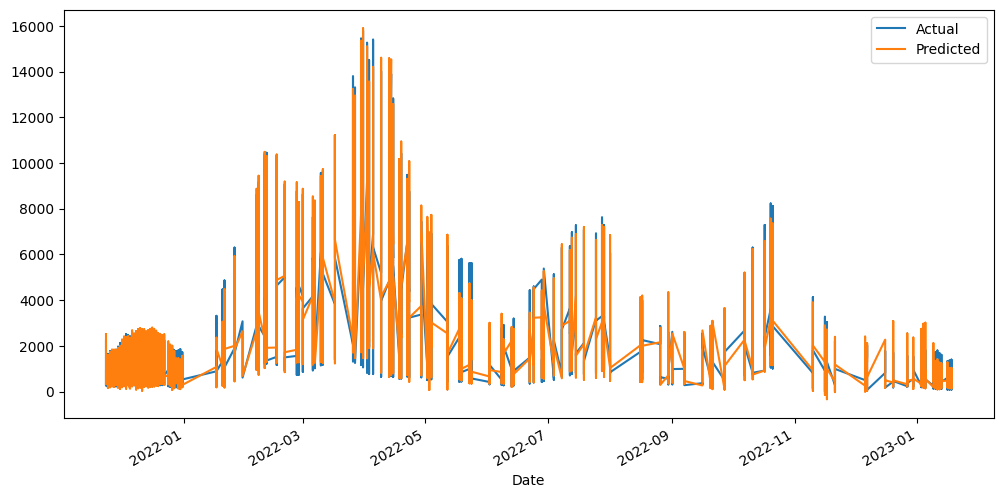

In [16]:
predictions_df.plot(figsize=(12,6))

In [18]:
from sklearn.metrics import precision_recall_fscore_support
# Convert the predicted and actual values back to their original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1,1)).ravel()
y_train = scaler.inverse_transform(y_train.reshape(-1,1)).ravel()
test_predict = scaler.inverse_transform(test_predict.reshape(-1,1)).ravel()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
# Define a threshold for classification
threshold = 0.5

# Bin the target values into discrete classes
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Convert the predicted values to binary
train_predict_binary = (train_predict > threshold).astype(int)
test_predict_binary = (test_predict > threshold).astype(int)

# Calculate precision, recall, and F1 score
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train_binary, train_predict_binary, average='binary')
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test_binary, test_predict_binary, average='binary')

print('Train Precision:', train_precision)
print('Train Recall:', train_recall)
print('Train F1 Score:', train_f1_score)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1 Score:', test_f1_score)

Train Precision: 0.9962184504441122
Train Recall: 0.9987656497972139
Train F1 Score: 0.9974904239862634
Test Precision: 0.9981481481481481
Test Recall: 0.9993819530284301
Test F1 Score: 0.9987646695491044
